# Floor Planning Example

In placement problems, the variables represent the coordinates of a number of points that are to be optimally placed. A <i>floor planning problem</i> can be considered an extension of a placement problem in two ways:

* The objects to be placed are rectangles or boxes aligned with the axes (as opposed to points), and must not overlap.
* Each rectangle or box to be placed can be reconfigured, within some limits. For example we might fix the area of each rectangle, but not the length and height separately.

The objective is usually to minimize the size (e.g., area, volume, perimeter) of the bounding box, which is the smallest box that contains the boxes to be configured and placed.

<img src="https://drive.google.com/uc?export=view&id=12n0Hwt9rccmTbjhEI3Gp9ZozS0JPMRRW" width="600"/>

The non-overlap constraints make the general floor planning problem a complicated combinatorial optimization problem or rectangle packing problem. However, if the relative positioning of the boxes is specified, several types of floor planning
problems can be formulated as convex optimization problems. 

In [4]:
# Figure 8.20, page 444.
# Floor planning example.

from cvxopt import solvers, matrix, spmatrix, mul, div
try: import pylab
except ImportError: pylab_installed = False
else: pylab_installed = True

def floorplan(Amin):

    #     minimize    W+H
    #     subject to  Amin1 / h1 <= w1
    #                 Amin2 / h2 <= w2
    #                 Amin3 / h3 <= w3
    #                 Amin4 / h4 <= w4
    #                 Amin5 / h5 <= w5
    #                 x1 >= 0
    #                 x2 >= 0
    #                 x4 >= 0
    #                 x1 + w1 + rho <= x3
    #                 x2 + w2 + rho <= x3
    #                 x3 + w3 + rho <= x5
    #                 x4 + w4 + rho <= x5
    #                 x5 + w5 <= W
    #                 y2 >= 0
    #                 y3 >= 0
    #                 y5 >= 0
    #                 y2 + h2 + rho <= y1
    #                 y1 + h1 + rho <= y4
    #                 y3 + h3 + rho <= y4
    #                 y4 + h4 <= H
    #                 y5 + h5 <= H
    #                 h1/gamma <= w1 <= gamma*h1
    #                 h2/gamma <= w2 <= gamma*h2
    #                 h3/gamma <= w3 <= gamma*h3
    #                 h4/gamma <= w4 <= gamma*h4
    #                 h5/gamma <= w5 <= gamma*h5
    #
    # 22 Variables W, H, x (5), y (5), w (5), h (5).
    #
    # W, H:  scalars; bounding box width and height
    # x, y:  5-vectors; coordinates of bottom left corners of blocks
    # w, h:  5-vectors; widths and heigths of the 5 blocks

    rho, gamma = 1.0, 5.0   # min spacing, min aspect ratio

    # The objective is to minimize W + H.  There are five nonlinear
    # constraints
    #
    #     -w1 + Amin1 / h1 <= 0
    #     -w2 + Amin2 / h2 <= 0
    #     -w3 + Amin3 / h3 <= 0
    #     -w4 + Amin4 / h4 <= 0
    #     -w5 + Amin5 / h5 <= 0.

    c = matrix(2*[1.0] + 20*[0.0])

    # linear inequalities
    G = matrix(0.0, (26,22))
    h = matrix(0.0, (26,1))

    # -x1 <= 0
    G[0,2] = -1.0

    # -x2 <= 0
    G[1,3] = -1.0

    # -x4 <= 0
    G[2,5] = -1.0

    # x1 - x3 + w1 <= -rho
    G[3, [2, 4, 12]], h[3] = [1.0, -1.0, 1.0], -rho

    # x2 - x3 + w2 <= -rho
    G[4, [3, 4, 13]], h[4] = [1.0, -1.0, 1.0], -rho

    # x3 - x5 + w3 <= -rho
    G[5, [4, 6, 14]], h[5] = [1.0, -1.0, 1.0], -rho

    # x4 - x5 + w4 <= -rho
    G[6, [5, 6, 15]], h[6] = [1.0, -1.0, 1.0], -rho

    # -W + x5 + w5 <= 0
    G[7, [0, 6, 16]] = -1.0, 1.0, 1.0

    # -y2 <= 0
    G[8,8] = -1.0

    # -y3 <= 0
    G[9,9] = -1.0

    # -y5 <= 0
    G[10,11] = -1.0

    # -y1 + y2 + h2 <= -rho
    G[11, [7, 8, 18]], h[11] = [-1.0, 1.0, 1.0], -rho

    # y1 - y4 + h1 <= -rho
    G[12, [7, 10, 17]], h[12] = [1.0, -1.0, 1.0], -rho

    # y3 - y4 + h3 <= -rho
    G[13, [9, 10, 19]], h[13] = [1.0, -1.0, 1.0], -rho

    # -H + y4 + h4 <= 0
    G[14, [1, 10, 20]] = -1.0, 1.0, 1.0

    # -H + y5 + h5 <= 0
    G[15, [1, 11, 21]] = -1.0, 1.0, 1.0

    # -w1 + h1/gamma <= 0
    G[16, [12, 17]] = -1.0, 1.0/gamma

    # w1 - gamma * h1 <= 0
    G[17, [12, 17]] = 1.0, -gamma

    # -w2 + h2/gamma <= 0
    G[18, [13, 18]] = -1.0, 1.0/gamma

    # w2 - gamma * h2 <= 0
    G[19, [13, 18]] = 1.0, -gamma

    # -w3 + h3/gamma <= 0
    G[20, [14, 18]] = -1.0, 1.0/gamma

    # w3 - gamma * h3 <= 0
    G[21, [14, 19]] = 1.0, -gamma

    # -w4  + h4/gamma <= 0
    G[22, [15, 19]] = -1.0, 1.0/gamma

    # w4 - gamma * h4 <= 0
    G[23, [15, 20]] = 1.0, -gamma

    # -w5 + h5/gamma <= 0
    G[24, [16, 21]] = -1.0, 1.0/gamma

    # w5 - gamma * h5 <= 0.0
    G[25, [16, 21]] = 1.0, -gamma

    # solve and return W, H, x, y, w, h
    sol = solvers.cpl(c, F, G, h)
    return  sol['x'][0], sol['x'][1], sol['x'][2:7], sol['x'][7:12], \
        sol['x'][12:17], sol['x'][17:]
        

The problem is defined as follows:

$$
    minimize \hspace{4.5cm} W + H \\
    subject \hspace{0.1cm} to \hspace{0.5cm} A_{min,k}/h_k \leq 0, \hspace{0.1cm} k=1,...,5 \\
    \hspace{3.5cm} x_1 \geq 0, \hspace{0.1cm} x_2 \geq 0, x_4 \geq 0 \\
    \hspace{4.7cm} x_1 + w_1 + \rho \leq x_3 \\
    \hspace{4.7cm} x_2 + w_2 + \rho \leq x_3 \\
    \hspace{4.7cm} x_3 + w_3 + \rho \leq x_5 \\
    \hspace{4.7cm} x_4 + w_4 + \rho \leq x_5 \\
    \hspace{5.5cm} x_5 + w_5 \leq W \\
    \hspace{3.5cm} y_2 \geq 0, y_3 \geq 0, y_5 \geq 0 \\
    \hspace{4.7cm} y_2 + h_2 + \rho \leq y_1 \\
    \hspace{4.7cm} y_1 + h_1 + \rho \leq y_4 \\
    \hspace{4.7cm} y_3 + h_3 + \rho \leq y_4 \\
    \hspace{2.7cm} y_4 + h_4 \leq H, \hspace{0.1cm} y_5 + h_5 \leq H \\
    \hspace{1.8cm} h_k/\gamma \leq w_k \leq \gamma h_k, \hspace{0.1cm} k = 1, ..., 5
$$

This problem has:
* 22 variables
* 5 nonlinear inequality constraints
* 26 linear inequality constraints

The code belows defines a function <b>floorplan</b> that solves the problem by calling <b>cp</b>, then applies it to 4 instances, and creates a figure

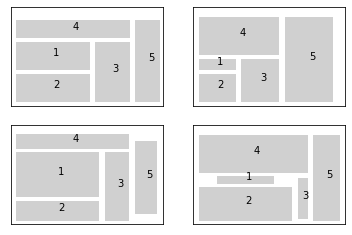

In [5]:
def F(x=None, z=None):
    if x is None:
        return 5, matrix(17*[0.0] + 5*[1.0])
    if min(x[17:]) <= 0.0:
        return None
    f = -x[12:17] + div(Amin, x[17:])
    Df = matrix(0.0, (5,22))
    Df[:,12:17] = spmatrix(-1.0, range(5), range(5))
    Df[:,17:] = spmatrix(-div(Amin, x[17:]**2), range(5), range(5))
    if z is None:
        return f, Df
    H = spmatrix( 2.0* mul(z, div(Amin, x[17::]**3)), range(17,22), 
                 range(17,22) )
    return f, Df, H

solvers.options['show_progress'] = False

if pylab_installed: pylab.figure(facecolor='w')

Amin = matrix([100., 100., 100., 100., 100.])
W, H, x, y, w, h =  floorplan(Amin)
if pylab_installed:
    if pylab_installed: pylab.subplot(221)
    for k in range(5):
        pylab.fill([x[k], x[k], x[k]+w[k], x[k]+w[k]],
                   [y[k], y[k]+h[k], y[k]+h[k], y[k]],
                   facecolor = '#D0D0D0')
        pylab.text(x[k]+.5*w[k], y[k]+.5*h[k], "%d" %(k+1))
    pylab.axis([-1.0, 26, -1.0, 26])
    pylab.xticks([])
    pylab.yticks([])

Amin = matrix([20., 50., 80., 150., 200.])
W, H, x, y, w, h =  floorplan(Amin)
if pylab_installed:
    pylab.subplot(222)
    for k in range(5):
        pylab.fill([x[k], x[k], x[k]+w[k], x[k]+w[k]],
                   [y[k], y[k]+h[k], y[k]+h[k], y[k]],
                   facecolor = '#D0D0D0')
        pylab.text(x[k]+.5*w[k], y[k]+.5*h[k], "%d" %(k+1))
    pylab.axis([-1.0, 26, -1.0, 26])
    pylab.xticks([])
    pylab.yticks([])

Amin = matrix([180., 80., 80., 80., 80.])
W, H, x, y, w, h =  floorplan(Amin)
if pylab_installed:
    pylab.subplot(223)
    for k in range(5):
        pylab.fill([x[k], x[k], x[k]+w[k], x[k]+w[k]],
                   [y[k], y[k]+h[k], y[k]+h[k], y[k]],
                   facecolor = '#D0D0D0')
        pylab.text(x[k]+.5*w[k], y[k]+.5*h[k], "%d" %(k+1))
    pylab.axis([-1.0, 26, -1.0, 26])
    pylab.xticks([])
    pylab.yticks([])

Amin = matrix([20., 150., 20., 200., 110.])
W, H, x, y, w, h =  floorplan(Amin)
if pylab_installed:
    pylab.subplot(224)
    for k in range(5):
        pylab.fill([x[k], x[k], x[k]+w[k], x[k]+w[k]],
                   [y[k], y[k]+h[k], y[k]+h[k], y[k]],
                   facecolor = '#D0D0D0')
        pylab.text(x[k]+.5*w[k], y[k]+.5*h[k], "%d" %(k+1))
    pylab.axis([-1.0, 26, -1.0, 26])
    pylab.xticks([])
    pylab.yticks([])

    pylab.show()